In [21]:
%load_ext autoreload
%autoreload 2

%load_ext rpy2.ipython

d:\it\coding\github projects\my-university\iii курс\(python) эконометрика\venv\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning:

The symbol 'quartz' is not in this R namespace/package.



In [51]:
import datetime as dt

import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
from IPython.display import Markdown
from arch import unitroot
from plotly.offline import iplot

from src.stats import LinearRegression, add_constant

# Исходные данные

In [23]:
word_table = """
№ 	год 	квартал 	IP
1	2007	1	137,73
2	2007	2	140,21
3	2007	3	145,53
4	2007	4	154,41
5	2008	1	146,07
6	2008	2	146,37
7	2008	3	148,42
8	2008	4	149,4
9	2009	1	123,41
10	2009	2	126,5
11	2009	3	134,09
12	2009	4	143,07
13	2010	1	133,2
14	2010	2	135,73
15	2010	3	139,67
16	2010	4	153,49
17	2011	1	139,83
18	2011	2	143,89
19	2011	3	147,05
20	2011	4	159,11
21	2012	1	145,91
22	2012	2	147,07
23	2012	3	151,93
24	2012	4	164,08
25	2013	1	144,06
26	2013	2	148,1
27	2013	3	152,69
28	2013	4	166,12
29	2014	1	145,52
30	2014	2	150,76
31	2014	3	154,83
32	2014	4	169,7
33	2015	1	144,92
34	2015	2	143,33
35	2015	3	148,34
36	2015	4	163,18
37	2016	1	143,92
38	2016	2	144,79
39	2016	3	148,12
40	2016	4	166,19
"""

In [24]:
series = pd.Series(
    data=[float(row.split('\t')[-1].replace(',', '.')) for row in word_table.strip().split('\n')[1:]],
    index=pd.date_range(dt.datetime(2007, 1, 1), dt.datetime(2016, 12, 31), freq='Q'),
    name='IP'
)
series.head()

2007-03-31    137.73
2007-06-30    140.21
2007-09-30    145.53
2007-12-31    154.41
2008-03-31    146.07
Freq: Q-DEC, Name: IP, dtype: float64

# График

In [27]:
iplot(px.line(x=series.index, y=series.array, title='IP'))

# Аддитивная модель сезонных индексов

In [90]:
decomposition = sm.tsa.seasonal_decompose(series, model='additive')

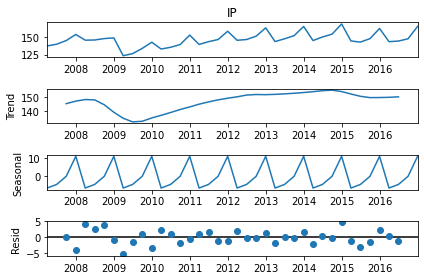

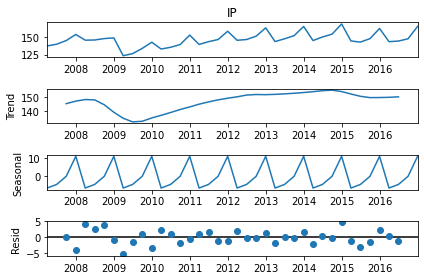

In [91]:
decomposition.plot()

# Аддитивная линейная модель роста

In [30]:
MODEL_DATA = pd.DataFrame(series)
MODEL_DATA['t'] = range(1, MODEL_DATA.shape[0] + 1)
MODEL_DATA

,IP,t
2007-03-31,137.73,1
2007-06-30,140.21,2
2007-09-30,145.53,3
2007-12-31,154.41,4
2008-03-31,146.07,5
2008-06-30,146.37,6
2008-09-30,148.42,7
2008-12-31,149.40,8
2009-03-31,123.41,9
2009-06-30,126.50,10


In [32]:
ones_zeroes = pd.Series([1 if i % 4 == 0 else 0 for i in range(MODEL_DATA.shape[0])])
ones_zeroes.index = MODEL_DATA.index
MODEL_DATA['d1'] = ones_zeroes

ones_zeroes = ones_zeroes.shift(1, fill_value=0)
ones_zeroes.index = MODEL_DATA.index
MODEL_DATA['d2'] = ones_zeroes

ones_zeroes = ones_zeroes.shift(1, fill_value=0)
ones_zeroes.index = MODEL_DATA.index
MODEL_DATA['d3'] = ones_zeroes

MODEL_DATA.head()

,IP,t,d1,d2,d3
2007-03-31,137.73,1,1,0,0
2007-06-30,140.21,2,0,1,0
2007-09-30,145.53,3,0,0,1
2007-12-31,154.41,4,0,0,0
2008-03-31,146.07,5,1,0,0


In [35]:

Y = MODEL_DATA[['IP']]
Y.head()

,IP
2007-03-31,137.73
2007-06-30,140.21
2007-09-30,145.53
2007-12-31,154.41
2008-03-31,146.07


In [36]:
X = add_constant(MODEL_DATA[['t', 'd1', 'd2', 'd3']])
X.head()

,const,t,d1,d2,d3
2007-03-31,1.0,1,1,0,0
2007-06-30,1.0,2,0,1,0
2007-09-30,1.0,3,0,0,1
2007-12-31,1.0,4,0,0,0
2008-03-31,1.0,5,1,0,0


In [37]:
model = LinearRegression(Y, X)

In [38]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     IP   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     18.21
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           3.58e-08
Time:                        20:13:14   Log-Likelihood:                -126.14
No. Observations:                  40   AIC:                             262.3
Df Residuals:                      35   BIC:                             270.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.1477      2.652     56.990      0.0

## Прогноз

In [81]:
exog = pd.DataFrame(
    None,
    index=pd.date_range(dt.date(year=2017, month=1, day=1), end=dt.date(year=2018, month=12, day=31), freq='Q'),
    columns=X.columns
)
exog['const'] = 1
exog['t'] = range(X['t'].iloc[-1] + 1, X['t'].iloc[-1] + 1 + len(exog))
exog.loc[:, ['d1', 'd2', 'd3']] = np.vstack([
    np.vstack([np.eye(3), np.zeros(3)])
    for _ in range(len(exog) // 4)]
)
exog = exog.astype(int)
exog

,const,t,d1,d2,d3
2017-03-31,1,41,1,0,0
2017-06-30,1,42,0,1,0
2017-09-30,1,43,0,0,1
2017-12-31,1,44,0,0,0
2018-03-31,1,45,1,0,0
2018-06-30,1,46,0,1,0
2018-09-30,1,47,0,0,1
2018-12-31,1,48,0,0,0


In [82]:
predicts = model.results.predict(exog)
predicts

2017-03-31    148.184333
2017-06-30    150.402333
2017-09-30    154.794333
2017-12-31    166.602333
2018-03-31    149.589303
2018-06-30    151.807303
2018-09-30    156.199303
2018-12-31    168.007303
Freq: Q-DEC, dtype: float64

In [83]:
fig = px.line(x=series.index, y=series.array)

In [84]:
plot_predicts = predicts.copy()
plot_predicts[series.index[-1]] = series.iloc[-1]
plot_predicts = plot_predicts.sort_index()

In [85]:
fig = fig.add_scatter(x=plot_predicts.index, y=plot_predicts.array, mode='lines', name='Прогноз')

In [86]:
iplot(fig)
